<a href="https://colab.research.google.com/github/teticio/audio-diffusion/blob/master/notebooks/test_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    # are we running on Google Colab?
    import google.colab
    !git clone -q https://github.com/teticio/audio-diffusion.git
    %cd audio-diffusion
    !pip install -q -r requirements.txt
except:
    pass

In [2]:
import os
import sys
sys.path.insert(0, os.path.dirname(os.path.abspath("")))

In [3]:
import random
import librosa
import numpy as np
from datasets import load_dataset
from IPython.display import Audio
from audiodiffusion.mel import Mel
from audiodiffusion import AudioDiffusion

In [4]:
def loop_it(audio, sample_rate, loops=12):
    tempo, beats = librosa.beat.beat_track(y=audio, sr=sample_rate, units='samples')
    if len(beats) > 8:
        return np.tile(audio[beats[0]: beats[8]], loops)
    if len(beats) > 4:
        return np.tile(audio[beats[0]: beats[4]], loops)
    return None

### Run model inference to generate mel spectrogram, audios and loops

In [5]:
audio_diffusion = AudioDiffusion(model_id="teticio/audio-diffusion-256")

In [ ]:
while True:
    image, (sample_rate, audio) = audio_diffusion.generate_spectrogram_and_audio()
    display(image)
    display(Audio(audio, rate=sample_rate))
    loop = loop_it(audio, sample_rate)
    if loop is not None:
        display(Audio(loop, rate=sample_rate))
    else:
        print("Unable to determine loop points")

### Compare results with random sample from training set

In [12]:
mel = Mel(x_res=256, y_res=256)

In [ ]:
ds = load_dataset('teticio/audio-diffusion-256')

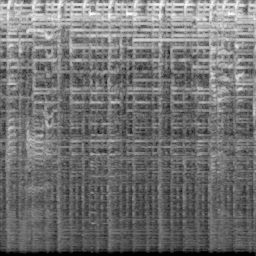

In [16]:
image = random.choice(ds['train'])['image']
image

In [17]:
audio = mel.image_to_audio(image)
Audio(data=audio, rate=mel.get_sample_rate())

### Push model to hub

In [ ]:
from diffusers.hub_utils import init_git_repo, push_to_hub


class AttributeDict(dict):

    def __getattr__(self, attr):
        return self[attr]

    def __setattr__(self, attr, value):
        self[attr] = value


args = AttributeDict({
    "hub_model_id":
    "teticio/audio-diffusion-256",
    "output_dir":
    "../ddpm-ema-audio-256-repo",
    "local_rank":
    -1,
    "hub_token":
    open(os.path.join(os.environ['HOME'], '.huggingface/token'), 'rt').read(),
    "hub_private_repo":
    False,
    "overwrite_output_dir":
    False
})

repo = init_git_repo(args, at_init=True)
ddpm = DDPMPipeline.from_pretrained('../ddpm-ema-audio-256')
push_to_hub(args, ddpm, repo)